# CISC-839 Data Analytics Project

## A Session Based - Recommendation System

This Sysyem is a session-based recommendation system, powered by the Ternec dataset. Leveraging the [Tenrec: A Large-scale Multipurpose Benchmark Dataset for Recommender Systems](https://proceedings.neurips.cc/paper_files/paper/2022/file/4ad4fc1528374422dd7a69dea9e72948-Paper-Datasets_and_Benchmarks.pdf) Paper, we aim to deliver personalized recommendations that adapt to users' session-specific preferences in real-time. Join us as we revolutionize the way users discover content by harnessing the power of session-based modeling and the rich insights provided by the Ternec dataset.

## Team Member
- Adham Mokhtar
- Manar El-Ghobashy
- Yara Hassan
- Yara El-Zahy

## Recommended Pipline
- Data Acquisition: Obtain the Ternec dataset, ensuring it contains the necessary session-based information, such as user interactions, session context, and item properties.

- Data Preprocessing: Clean the dataset by removing duplicate or irrelevant entries, handling missing values, and normalizing or transforming features as required. Split the dataset into training, validation, and test sets.

- Session Representation: Convert the session-based data into a suitable representation, such as sequences or graphs, to capture the temporal dynamics and dependencies between user actions.

- Feature Engineering: Extract relevant features from the dataset, such as item attributes, timestamps, or session context, to enhance the recommendation model's understanding of user preferences.

- Model Selection: Explore various session-based recommendation models, such as Recurrent Neural Networks (RNNs), Transformer-based models, or Graph Neural Networks (GNNs), considering their ability to capture temporal patterns and handle session-based data.

- Model Training: Train the selected model using the training dataset and optimize its hyperparameters using the validation set. Apply appropriate loss functions, regularization techniques, and optimization algorithms to enhance the model's performance.

- Model Evaluation: Evaluate the trained model on the test dataset using suitable evaluation metrics like precision, recall, or Mean Average Precision (MAP). Analyze the model's performance to gain insights into its strengths and weaknesses.

- Hyperparameter Tuning: Fine-tune the model's hyperparameters using techniques like grid search or random search to further optimize its performance. Validate the tuned model using the validation set.

- Performance Analysis: Conduct an in-depth analysis of the recommendation results, considering factors like recommendation diversity, novelty, and coverage. Incorporate user feedback and iterate on the model or pipeline as necessary.

- Deployment: Once satisfied with the model's performance, deploy it in a production environment to generate real-time recommendations. Implement mechanisms to handle new user sessions, adapt to changing user preferences, and ensure scalability and efficiency.

- Monitoring and Maintenance: Continuously monitor the recommendation system's performance, gather user feedback, and update the model periodically to reflect evolving user preferences and market trends.

## Import Libraries

In [1]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf

# from bert4rec import BERT4Rec



import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline

## Usefull/Common Methods

In [2]:
def display_value_counts_bar(df, cols_per_row, total_size):
    nrows = int(np.ceil(len(df.columns)/cols_per_row))
    _, axes = plt.subplots(nrows=nrows, ncols=cols_per_row, figsize=(20, 20))
    row_index = 0
    column_index = 0
    count = 0
    for column in df.columns:
        if count < total_size:
            if nrows > 1:
                ax = axes[row_index, column_index]
            else:
                ax = axes[row_index]
            ax.set_title(column)
            ax.tick_params(axis='x', labelrotation = 90)

            top_counts = df[column].value_counts().sort_values(ascending=False).head(10)
            top_counts.plot.bar(ax=ax)

            column_index += 1
            if column_index % cols_per_row == 0:
                row_index += 1
                column_index = 0
            count += 1

    plt.tight_layout()
    plt.show()

## Data Acquisition
Data is already there but once it is a huge data (exactly 14.7 GB) near to a half billion record (exactly 493,458,971 record), we will use like a 10% of the data on preprocessing, EDA, models training and models evaluation.

So, we will create a new file with this percentage first.

In [3]:
real_data_size = 493458971
new_data_size = real_data_size * 0.001 # As a start and till we reach a good point and before submission lets just try this amount of data.
new_data_size

493458.971

In [4]:
with open('Tenrec/QK-video.csv', 'r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    new_data = []
    for index, line in enumerate(reader):
        # Process each line of the file
        if index <= new_data_size:
            new_data.append(line)
        else:
            break

In [5]:
len(new_data)

493459

In [6]:
with open('QK-video-01-percent.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(new_data)

In [7]:
data = pd.read_csv('QK-video-01-percent.csv')

In [8]:
data.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age
0,1,1,1,0,0,0,1,1,1,4
1,1,2,1,0,0,0,1,1,1,4
2,1,3,1,0,0,0,0,1,1,4
3,1,4,0,0,0,0,1,0,1,4
4,2,5,1,0,0,0,1,1,1,4


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493458 entries, 0 to 493457
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   user_id         493458 non-null  int64 
 1   item_id         493458 non-null  int64 
 2   click           493458 non-null  int64 
 3   follow          493458 non-null  int64 
 4   like            493458 non-null  int64 
 5   share           493458 non-null  int64 
 6   video_category  493458 non-null  object
 7   watching_times  493458 non-null  int64 
 8   gender          493458 non-null  int64 
 9   age             493458 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 37.6+ MB


## Data Preprocessing

Steps for Session-Based Recommendation:

- Duplicate Removal: Identify and remove any duplicate entries in the dataset to ensure data integrity and prevent bias in the recommendation process.

- Irrelevant Entry Removal: Eliminate entries that are irrelevant to session-based recommendations, such as non-session interactions or incomplete data.

- Missing Value Handling: Address missing values in the dataset, either by imputing them using appropriate techniques (e.g., mean imputation, regression imputation) or removing instances with missing values, depending on the impact on the overall dataset quality.

- Session Length Filtering: Filter out sessions with insufficient data, ensuring an adequate number of interactions within each session to capture meaningful patterns.

- Session Sorting: Sort the dataset by session and timestamp to establish the temporal order of user interactions within sessions.

- Session Padding: Pad sessions with zero or placeholder values to ensure uniform length, allowing the model to handle sessions of varying lengths efficiently.

- Encoding Categorical Features: Encode categorical features, such as item IDs or session context, into numerical representations suitable for model training (e.g., one-hot encoding, label encoding).

- Normalization or Scaling: Normalize or scale numerical features, such as timestamps or session durations, to a common range to prevent any undue influence on the recommendation model.

- Train-Test Split: Split the preprocessed dataset into training and testing sets, ensuring a representative distribution of sessions and interactions in each.

- Validation Set Creation: Further split the training set into a smaller validation set, which can be used for hyperparameter tuning and model evaluation during the training process.



In [10]:
data.duplicated().sum()

0

In [11]:
data.isnull().sum()

user_id           0
item_id           0
click             0
follow            0
like              0
share             0
video_category    0
watching_times    0
gender            0
age               0
dtype: int64

<Axes: >

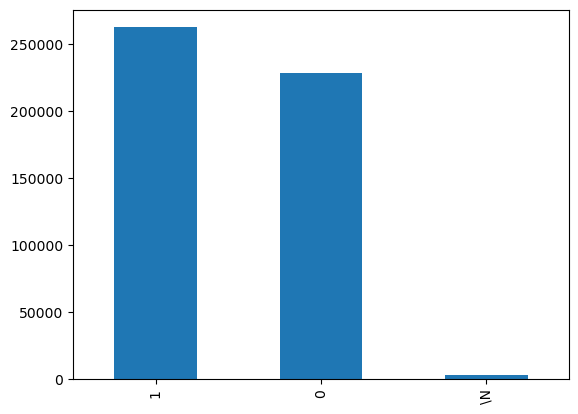

In [12]:
data['video_category'].value_counts().plot.bar()

In [13]:
# drop `\N` records in video_category
data = data[data['video_category'] != "\\N"]

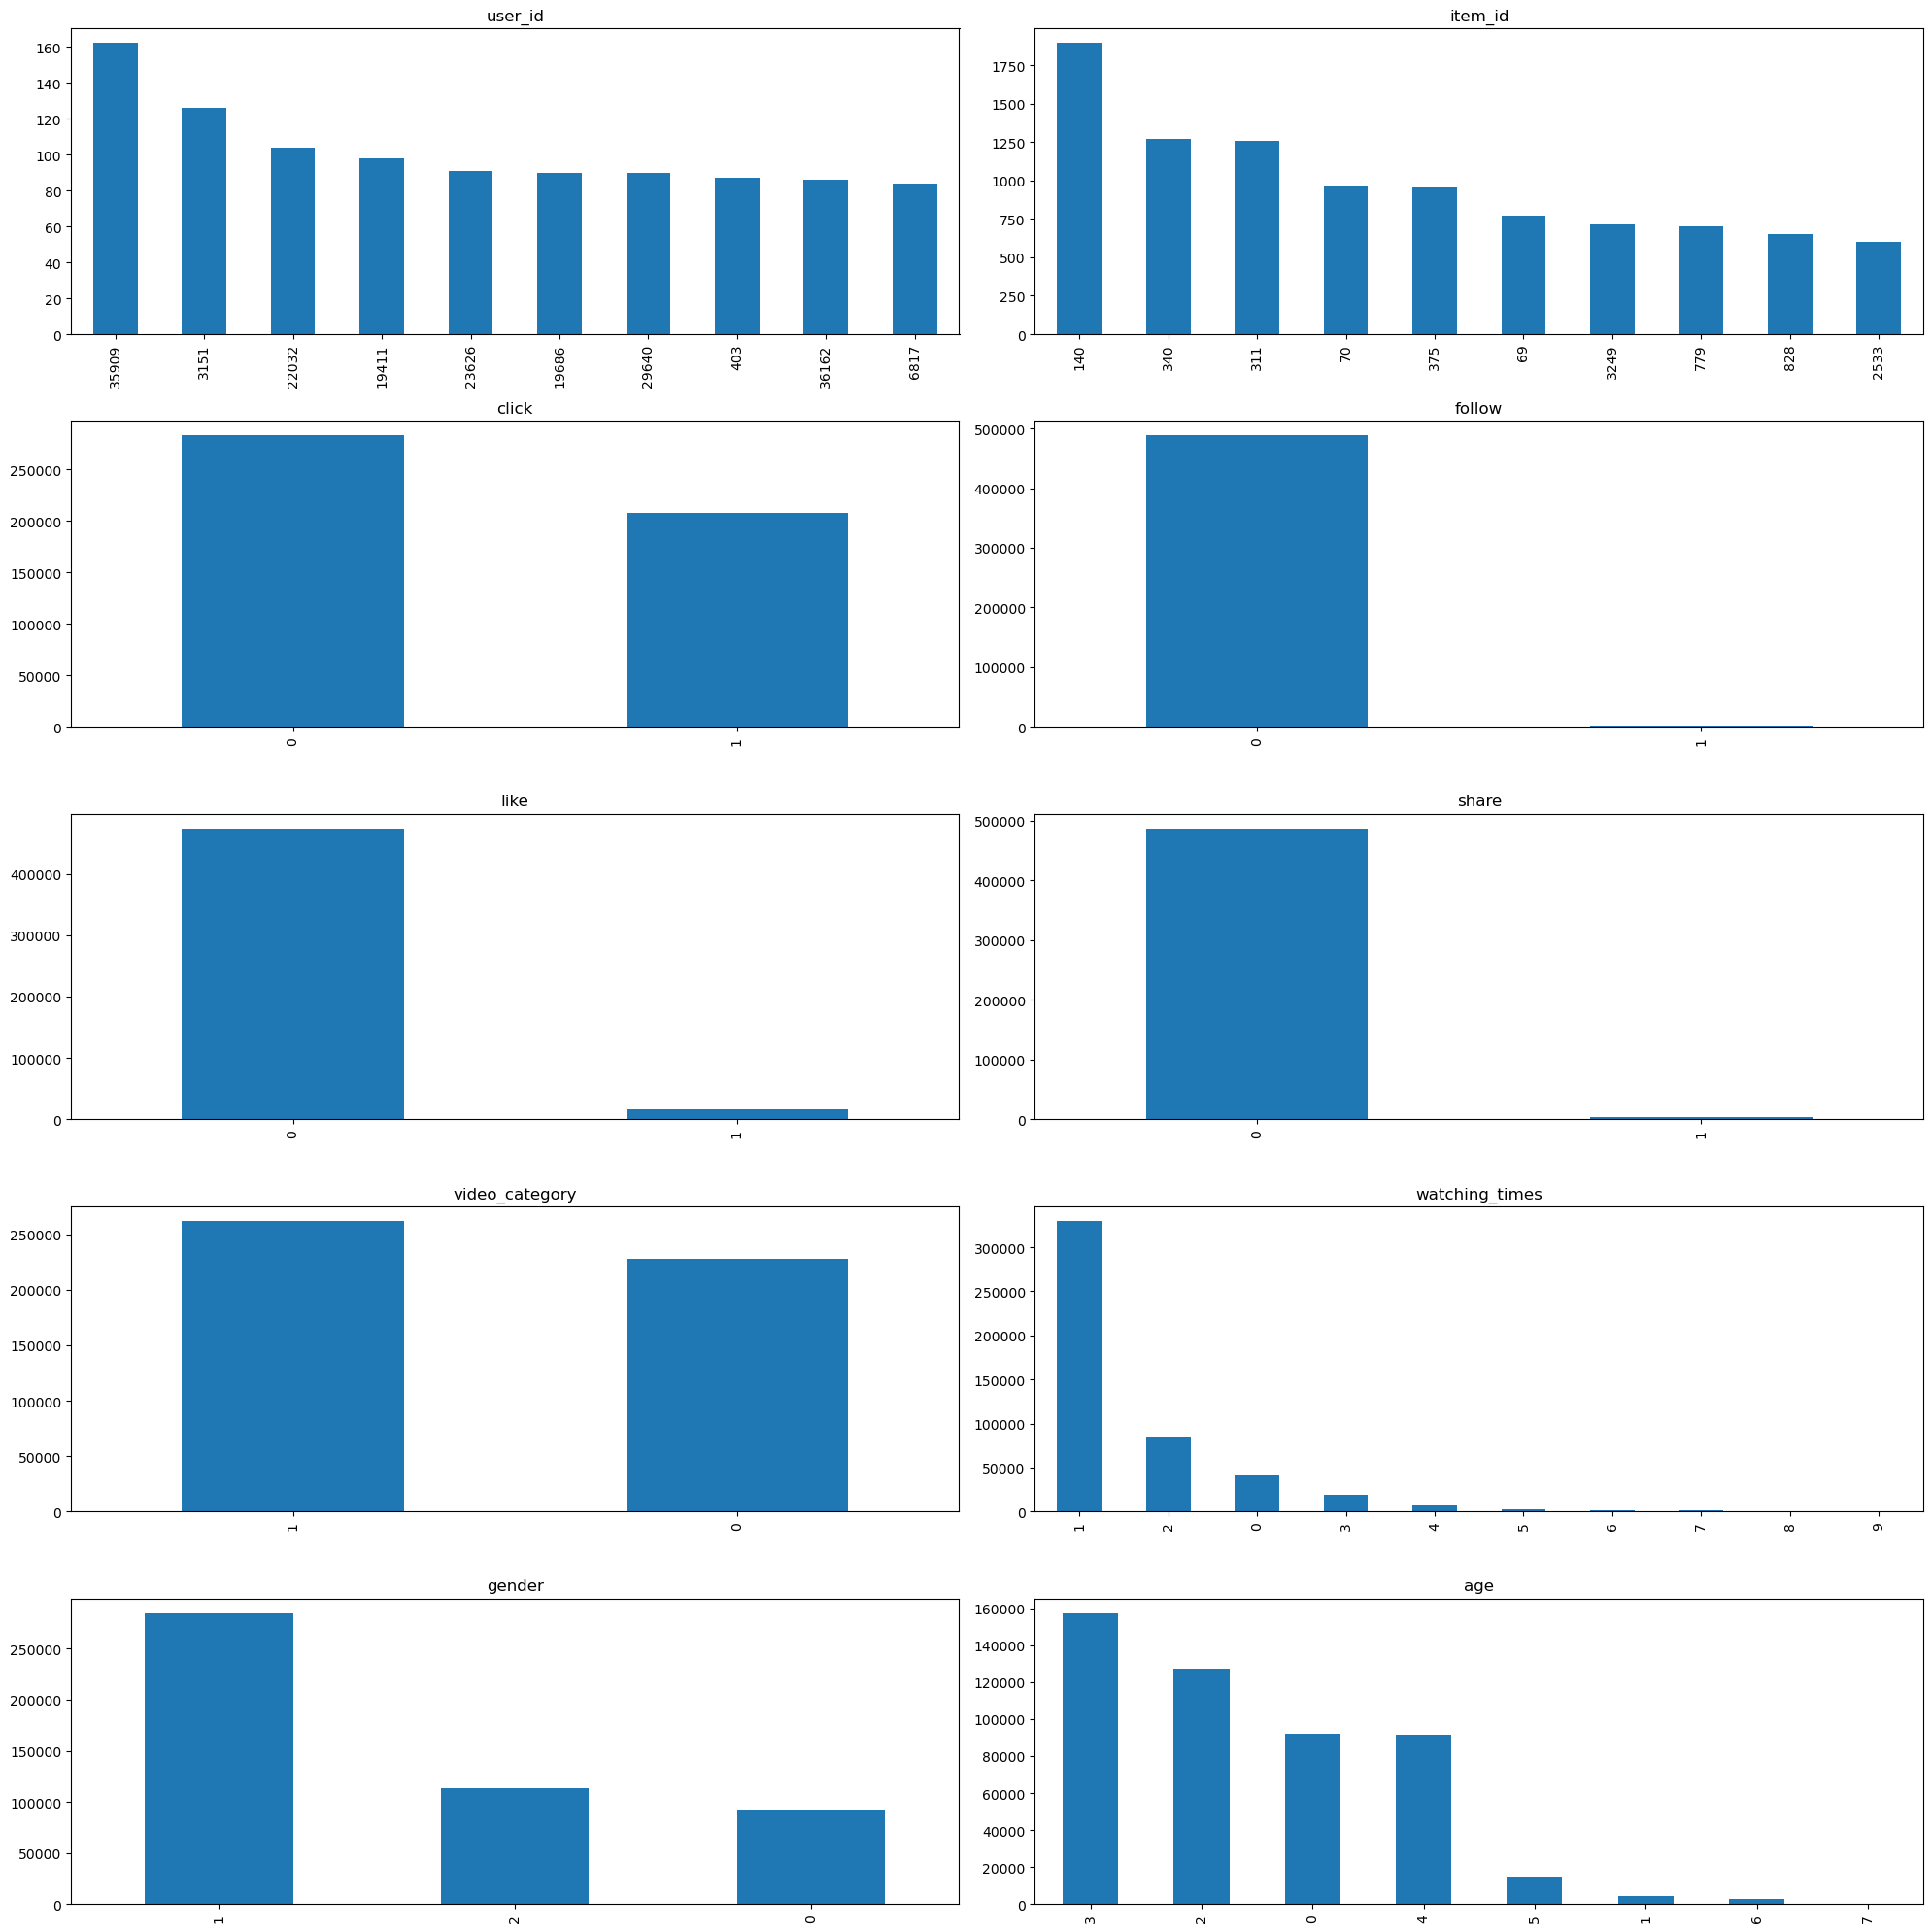

In [14]:
display_value_counts_bar(data, 2, len(data.columns))